# MGI cohort descriptions

Click the triangle (▶/▼) to expand/hide a section

In [0]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

PROJECT_ID = 'mlforhc2019-data'

## Setup (Connect to BigQuery)

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Table 1: Cohort Characteristics

### Number of unique patients

In [0]:
%%bigquery --project $PROJECT_ID
SELECT COUNT(DISTINCT patientID) AS numPatients FROM MGI_Data.PatientInfoAll

,numPatients
0,58624


### Number of unique primary encounters

In [0]:
%%bigquery --project $PROJECT_ID
SELECT COUNT(DISTINCT COALESCE(PrimaryEncounterID, ENCOUNTERID)) AS numEncounters FROM `MGI_Data.EncounterProperties`

,numEncounters
0,15799232


In [0]:
# These are incorrect
# %%bigquery --project $PROJECT_ID
# SELECT COUNT(DISTINCT EncounterID) AS numEncounters FROM `MGI_Data.EncounterProperties` WHERE PrimaryEncounterID = EncounterID OR PrimaryEncounterID IS NULL

# %%bigquery --project $PROJECT_ID
# SELECT COUNT(*) AS numEncounters FROM `MGI_Data.EncounterProperties` WHERE PrimaryEncounterID = EncounterID OR PrimaryEncounterID IS NULL

### Gender distribution

In [0]:
%%bigquery --project $PROJECT_ID
SELECT GenderName,
       COUNT(distinct patientID) as ct
FROM `MGI_Data.PatientInfoAll`
GROUP BY GenderName
ORDER BY ct desc;

,GenderName,ct
0,Female,31170
1,Male,27454


### Age distribution

* For each patient, take the max age (in years). 
* Patients over the age of 89 have their age appear as 300. 

In [0]:
%%bigquery df_age --project $PROJECT_ID
SELECT PatientID, MAX(AgeInYears) AS MaxAge FROM MGI_Data.Encounter GROUP BY PatientID 

In [0]:
pd.DataFrame(df_age['MaxAge'].describe())

,MaxAge
count,58624.000000
mean,56.604206
std,24.225901
min,18.000000
25%,44.000000
50%,58.000000
75%,68.000000
max,300.000000


### Date range of data span for each patient

In [0]:
%%bigquery df_daterange --project $PROJECT_ID
SELECT
    e.PatientID,
    min(e.ActivityDate) AS minDate,
    max(e.ActivityDate) AS maxDate
FROM
    MGI_Data.Encounter e JOIN
    MGI_Data.EncounterProperties ep ON e.encounterID = ep.encounterID
WHERE
    ep.HasLabs + ep.HasMeds + ep.HasObservations + ep.HasOrders + ep.HasProblems + ep.HasProcedures >= 1
    AND e.ActivityDate > TIMESTAMP('1900-01-01 00:00:00+00:00')
    AND e.ActivityDate < TIMESTAMP('2019-06-01 00:00:00+00:00')
GROUP BY e.PatientID

In [0]:
df_daterange['range'] = df_daterange['maxDate'] - df_daterange['minDate']
df_daterange['rangeInYears'] = df_daterange['range'].apply(lambda r: r.total_seconds() / (3600*24*365.25))

In [0]:
df_daterange['rangeInYears'].describe()

count    58624.000000
mean         8.405622
std          6.958799
min          0.000000
25%          2.050650
50%          6.173854
75%         15.143053
max         67.096509
Name: rangeInYears, dtype: float64

In [0]:
(df_daterange['rangeInYears'] > 4).mean()

0.6138612172489083

### Primary encounter counts per patient

In [0]:
%%bigquery df_enc_counts --project $PROJECT_ID
SELECT 
    p.PatientID,
    COUNT(DISTINCT COALESCE(ep.PrimaryEncounterID, ep.EncounterID)) AS EncounterCount
FROM
    MGI_Data.PatientInfoAll p
    LEFT OUTER JOIN MGI_Data.Encounter e ON e.PatientID = p.PatientID
    AND e.ActivityDate > TIMESTAMP('1900-01-01 00:00:00+00:00')
    AND e.ActivityDate < TIMESTAMP('2019-06-01 00:00:00+00:00')
    LEFT OUTER JOIN MGI_Data.EncounterProperties ep
        ON ep.EncounterID = e.EncounterID AND HasLabs + HasMeds + HasObservations + HasOrders + HasProblems + HasProcedures > 0
GROUP BY p.PatientID

In [0]:
df_enc_counts.describe()

,EncounterCount
count,58624.000000
mean,138.757130
std,171.005321
min,1.000000
25%,31.000000
50%,74.000000
75%,181.000000
max,2199.000000


### Inpatient visits

In [0]:
%%bigquery df_IP_counts --project $PROJECT_ID
SELECT 
    p.PatientID,
    COUNT(DISTINCT COALESCE(ep.PrimaryEncounterID, ep.EncounterID)) AS EncounterCount
FROM
    MGI_Data.PatientInfoAll p
    LEFT OUTER JOIN MGI_Data.Encounter e on e.PatientID = p.PatientID
    AND e.ActivityDate > TIMESTAMP('1900-01-01 00:00:00+00:00')
    AND e.ActivityDate < TIMESTAMP('2019-06-01 00:00:00+00:00')
    LEFT OUTER JOIN MGI_Data.EncounterProperties ep
    ON ep.EncounterID = e.EncounterID AND HasLabs + HasMeds + HasObservations + HasOrders + HasProblems + HasProcedures > 0
        AND ep.EncounterPatientClassName = 'Inpatient'
GROUP BY p.PatientID

In [0]:
df_IP_counts.describe()

,EncounterCount
count,58624.000000
mean,1.073195
std,2.203500
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,69.000000


### Non-inpatient visits

In [0]:
%%bigquery df_NIP_counts --project $PROJECT_ID
SELECT 
    p.PatientID,
    COUNT(DISTINCT COALESCE(ep.PrimaryEncounterID, ep.EncounterID)) AS EncounterCount
FROM
    MGI_Data.PatientInfoAll p
    LEFT OUTER JOIN MGI_Data.Encounter e on e.PatientID = p.PatientID
    AND e.ActivityDate > TIMESTAMP('1900-01-01 00:00:00+00:00')
    AND e.ActivityDate < TIMESTAMP('2019-06-01 00:00:00+00:00')
    LEFT OUTER JOIN MGI_Data.EncounterProperties ep
    ON ep.EncounterID = e.EncounterID AND HasLabs + HasMeds + HasObservations + HasOrders + HasProblems + HasProcedures > 0
        AND (ep.EncounterPatientClassName <> 'Inpatient' or ep.EncounterPatientClassName is NULL)
GROUP BY p.PatientID

In [0]:
df_NIP_counts.describe()

,EncounterCount
count,58624.000000
mean,138.074321
std,170.552121
min,0.000000
25%,30.000000
50%,73.000000
75%,180.000000
max,2195.000000


### Charted nursing observations

In [0]:
#@title Generate part of the query string...

vitals1 = [
    'SpO2',
    'Temperature',
    'RespiratoryRate',
    'BPMeanInvasive',
    'BPDiaInvasive',
    'BPSysInvasive',
    'BPMeanNonInvasive',
    'BPDiaNonInvasive',
    'BPSysNonInvasive',
    'HeartRate',
]
vitals2 = [
    'VentModeCategory',
    'BladderPressure',
    'PressureSupportSet',
    'FiO2Set',
    'PEEPSet',
    'FiO2Actual',
    'PaO2',
    'TidalVolumeSet',
    'TidalVolumeActual',
    'RespiratoryRateActual',
    'RespiratoryRateSet',
    'PainScoreTermName',
    'PainScoreValue',
]

for v in vitals1:
    print('    COUNT({v}) AS ct_{v},'.format(v=v))

print()
for v in vitals2:
    print('    COUNT({v}) AS ct_{v},'.format(v=v))

In [0]:
%%bigquery df_patients --project $PROJECT_ID
SELECT DISTINCT PatientID FROM MGI_Data.PatientInfoAll

In [0]:
%%bigquery df_vitals1_ct --project $PROJECT_ID
SELECT 
    PatientID,
    COUNT(SpO2) AS ct_SpO2,
    COUNT(Temperature) AS ct_Temperature,
    COUNT(RespiratoryRate) AS ct_RespiratoryRate,
    COUNT(BPMeanInvasive) AS ct_BPMeanInvasive,
    COUNT(BPDiaInvasive) AS ct_BPDiaInvasive,
    COUNT(BPSysInvasive) AS ct_BPSysInvasive,
    COUNT(BPMeanNonInvasive) AS ct_BPMeanNonInvasive,
    COUNT(BPDiaNonInvasive) AS ct_BPDiaNonInvasive,
    COUNT(BPSysNonInvasive) AS ct_BPSysNonInvasive,
    COUNT(HeartRate) AS ct_HeartRate
FROM MGI_Data.NursingStandardVitalSigns
GROUP BY PatientID

In [0]:
%%bigquery df_vitals2_ct --project $PROJECT_ID
SELECT 
    PatientID,
    COUNT(VentModeCategory) AS ct_VentModeCategory,
    COUNT(BladderPressure) AS ct_BladderPressure,
    COUNT(PressureSupportSet) AS ct_PressureSupportSet,
    COUNT(FiO2Set) AS ct_FiO2Set,
    COUNT(PEEPSet) AS ct_PEEPSet,
    COUNT(FiO2Actual) AS ct_FiO2Actual,
    COUNT(PaO2) AS ct_PaO2,
    COUNT(TidalVolumeSet) AS ct_TidalVolumeSet,
    COUNT(TidalVolumeActual) AS ct_TidalVolumeActual,
    COUNT(RespiratoryRateActual) AS ct_RespiratoryRateActual,
    COUNT(RespiratoryRateSet) AS ct_RespiratoryRateSet,
    COUNT(PainScoreTermName) AS ct_PainScoreTermName,
    COUNT(PainScoreValue) AS ct_PainScoreValue
FROM MGI_Data.NursingUncommonVitalSigns
GROUP BY PatientID

In [0]:
df_vitals_ct = df_patients.set_index('PatientID') \
    .join(df_vitals1_ct.set_index('PatientID'), how='outer') \
    .join(df_vitals2_ct.set_index('PatientID'), how='outer') \
    .fillna(0)

In [0]:
pd.DataFrame(df_vitals_ct.T.sum()).describe()

,0
count,58624.000000
mean,618.568726
std,1647.694437
min,0.000000
25%,64.000000
50%,176.000000
75%,521.000000
max,79675.000000


### Labs

In [0]:
%%bigquery df_lab_count --project $PROJECT_ID
SELECT 
    p.PatientID,
    COUNT(DISTINCT lr.RDW_Labresult_id) AS LabCount
FROM 
    MGI_Data.PatientInfoAll p LEFT OUTER JOIN 
    MGI_Data.LabResults lr ON p.PatientID = lr.PatientID
GROUP BY p.PatientID

In [0]:
df_lab_count.describe()

,LabCount
count,58624.000000
mean,692.301139
std,1498.500836
min,0.000000
25%,59.000000
50%,213.000000
75%,661.000000
max,27883.000000


### Medications

In [0]:
%%bigquery df_med_count --project $PROJECT_ID
SELECT 
    p.PatientID,
    COUNT(DISTINCT MA.MedicationAdministrationID) AS MedCount
FROM 
    MGI_Data.PatientInfoAll p LEFT OUTER JOIN
    MGI_Data.MedicationAdministrationsComprehensive ma on p.PatientID = ma.PatientID
GROUP BY p.PatientID

In [0]:
df_med_count.describe()

,MedCount
count,58624.000000
mean,216.377661
std,665.978059
min,0.000000
25%,12.000000
50%,45.000000
75%,161.000000
max,21740.000000


### Comorbidities

In [0]:
%%bigquery df_pat_elix_cnt --project $PROJECT_ID
SELECT 
    p.PatientID, 
    COALESCE(d.ComorbidityCount, 0) AS ComorbidityCount
FROM MGI_Data.PatientInfoAll p 
LEFT OUTER JOIN
(
    SELECT 
        i.PatientID,
        i.ElixhauserAlcoholAbuse + i.ElixhauserBloodLossAnemia
            + i.ElixhauserCardiacArrhythmias + i.ElixhauserChronicPulmonaryDisease + i.ElixhauserCoagulopathy
            + i.ElixhauserCongestiveHeartFailure + i.ElixhauserDeficiencyAnemia + i.ElixhauserDepression
            + i.ElixhauserDiabetesComplicated + i.ElixhauserDiabetesUncomplicated + i.ElixhauserDrugAbuse
            + i.ElixhauserFluidElectrolyteDisorders + i.ElixhauserHypertensionComplicated
            + i.ElixhauserHypertensionUncomplicated + i.ElixhauserHypothyroidism + i.ElixhauserLiverDisease
            + i.ElixhauserLymphoma + i.ElixhauserMetastaticCancer + i.ElixhauserObesity
            + i.ElixhauserOtherNeurologicalDisorders + i.ElixhauserParalysis
            + i.ElixhauserPepticUlcerDiseaseExcludingBleeding + i.ElixhauserPeripheralVascularDisorders
            + i.ElixhauserPsychoses + i.ElixhauserPulmonaryCirculationDisorders + i.ElixhauserRenalFailure
            + i.ElixhauserRheumatoidArthritisCollagenVascularDiseases + i.ElixhauserSolidTumorWithoutMetastasis
            + i.ElixhauserValvularDisease + i.ElixhauserWeightLoss 
        AS ComorbidityCount
    FROM
    (
        SELECT 
            p.patientID,
            MAX(CASE WHEN ElixhauserAlcoholAbuse >= 0 THEN elix.ElixhauserAlcoholAbuse ELSE 0 end) AS ElixhauserAlcoholAbuse,
            MAX(CASE WHEN ElixhauserBloodLossAnemia >= 0 THEN elix.ElixhauserBloodLossAnemia ELSE 0 end) AS ElixhauserBloodLossAnemia,
            MAX(CASE WHEN ElixhauserCardiacArrhythmias >= 0 THEN elix.ElixhauserCardiacArrhythmias ELSE 0 end) AS ElixhauserCardiacArrhythmias,
            MAX(CASE WHEN ElixhauserChronicPulmonaryDisease >= 0 THEN elix.ElixhauserChronicPulmonaryDisease ELSE 0 end) AS ElixhauserChronicPulmonaryDisease,
            MAX(CASE WHEN ElixhauserCoagulopathy >= 0 THEN elix.ElixhauserCoagulopathy ELSE 0 end) AS ElixhauserCoagulopathy,
            MAX(CASE WHEN ElixhauserCongestiveHeartFailure >= 0 THEN elix.ElixhauserCongestiveHeartFailure ELSE 0 end) AS ElixhauserCongestiveHeartFailure,
            MAX(CASE WHEN ElixhauserDeficiencyAnemia >= 0 THEN elix.ElixhauserDeficiencyAnemia ELSE 0 end) AS ElixhauserDeficiencyAnemia,
            MAX(CASE WHEN ElixhauserDepression >= 0 THEN elix.ElixhauserDepression ELSE 0 end) AS ElixhauserDepression,
            MAX(CASE WHEN ElixhauserDiabetesComplicated >= 0 THEN elix.ElixhauserDiabetesComplicated ELSE 0 end) AS ElixhauserDiabetesComplicated,
            MAX(CASE WHEN ElixhauserDiabetesUncomplicated >= 0 THEN elix.ElixhauserDiabetesUncomplicated ELSE 0 end) AS ElixhauserDiabetesUncomplicated,
            MAX(CASE WHEN ElixhauserDrugAbuse >= 0 THEN elix.ElixhauserDrugAbuse ELSE 0 end) AS ElixhauserDrugAbuse,
            MAX(CASE WHEN ElixhauserFluidElectrolyteDisorders >= 0 THEN elix.ElixhauserFluidElectrolyteDisorders ELSE 0 end) AS ElixhauserFluidElectrolyteDisorders,
            MAX(CASE WHEN ElixhauserHypertensionComplicated >= 0 THEN elix.ElixhauserHypertensionComplicated ELSE 0 end) AS ElixhauserHypertensionComplicated,
            MAX(CASE WHEN ElixhauserHypertensionUncomplicated >= 0 THEN elix.ElixhauserHypertensionUncomplicated ELSE 0 end) AS ElixhauserHypertensionUncomplicated,
            MAX(CASE WHEN ElixhauserHypothyroidism >= 0 THEN elix.ElixhauserHypothyroidism ELSE 0 end) AS ElixhauserHypothyroidism,
            MAX(CASE WHEN ElixhauserLiverDisease >= 0 THEN elix.ElixhauserLiverDisease ELSE 0 end) AS ElixhauserLiverDisease,
            MAX(CASE WHEN ElixhauserLymphoma >= 0 THEN elix.ElixhauserLymphoma ELSE 0 end) AS ElixhauserLymphoma,
            MAX(CASE WHEN ElixhauserMetastaticCancer >= 0 THEN elix.ElixhauserMetastaticCancer ELSE 0 end) AS ElixhauserMetastaticCancer,
            MAX(CASE WHEN ElixhauserObesity >= 0 THEN elix.ElixhauserObesity ELSE 0 end) AS ElixhauserObesity,
            MAX(CASE WHEN ElixhauserOtherNeurologicalDisorders >= 0 THEN elix.ElixhauserOtherNeurologicalDisorders ELSE 0 end) AS ElixhauserOtherNeurologicalDisorders,
            MAX(CASE WHEN ElixhauserParalysis >= 0 THEN elix.ElixhauserParalysis ELSE 0 end) AS ElixhauserParalysis,
            MAX(CASE WHEN ElixhauserPepticUlcerDiseaseExcludingBleeding >= 0 THEN elix.ElixhauserPepticUlcerDiseaseExcludingBleeding ELSE 0 end) AS ElixhauserPepticUlcerDiseaseExcludingBleeding,
            MAX(CASE WHEN ElixhauserPeripheralVascularDisorders >= 0 THEN elix.ElixhauserPeripheralVascularDisorders ELSE 0 end) AS ElixhauserPeripheralVascularDisorders,
            MAX(CASE WHEN ElixhauserPsychoses >= 0 THEN elix.ElixhauserPsychoses ELSE 0 end) AS ElixhauserPsychoses,
            MAX(CASE WHEN ElixhauserPulmonaryCirculationDisorders >= 0 THEN elix.ElixhauserPulmonaryCirculationDisorders ELSE 0 end) AS ElixhauserPulmonaryCirculationDisorders,
            MAX(CASE WHEN ElixhauserRenalFailure >= 0 THEN elix.ElixhauserRenalFailure ELSE 0 end) AS ElixhauserRenalFailure,
            MAX(CASE WHEN ElixhauserRheumatoidArthritisCollagenVascularDiseases >= 0 THEN elix.ElixhauserRheumatoidArthritisCollagenVascularDiseases ELSE 0 end) AS ElixhauserRheumatoidArthritisCollagenVascularDiseases,
            MAX(CASE WHEN ElixhauserSolidTumorWithoutMetastasis >= 0 THEN elix.ElixhauserSolidTumorWithoutMetastasis ELSE 0 end) AS ElixhauserSolidTumorWithoutMetastasis,
            MAX(CASE WHEN ElixhauserValvularDisease >= 0 THEN elix.ElixhauserValvularDisease ELSE 0 end) AS ElixhauserValvularDisease,
            MAX(CASE WHEN ElixhauserWeightLoss >= 0 THEN elix.ElixhauserWeightLoss ELSE 0 end) AS ElixhauserWeightLoss
        FROM MGI_Data.PatientInfoAll p
            JOIN MGI_Data.Encounter e
                ON e.PatientID = p.patientID
            JOIN MGI_Data.EncounterComorbiditiesElixhauser elix
                ON elix.EncounterID = e.EncounterID
        GROUP BY p.patientID
    ) i
) d
ON d.PatientID = p.PatientID

In [0]:
df_pat_elix_cnt.describe()

,ComorbidityCount
count,75623.000000
mean,4.686352
std,3.772864
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,26.000000


## Table 2: Distribution of comorbidities according to the 30 Elixhauser comorbidity measures. 


In [0]:
#@title Generate part of the query string...

elixhauser = [
    'ElixhauserCongestiveHeartFailure',
    'ElixhauserCardiacArrhythmias',
    'ElixhauserValvularDisease',
    'ElixhauserPulmonaryCirculationDisorders',
    'ElixhauserPeripheralVascularDisorders',
    'ElixhauserHypertensionUncomplicated',
    'ElixhauserHypertensionComplicated',
    'ElixhauserParalysis',
    'ElixhauserOtherNeurologicalDisorders',
    'ElixhauserChronicPulmonaryDisease',
    'ElixhauserDiabetesUncomplicated',
    'ElixhauserDiabetesComplicated',
    'ElixhauserHypothyroidism',
    'ElixhauserRenalFailure',
    'ElixhauserLiverDisease',
    'ElixhauserPepticUlcerDiseaseExcludingBleeding',
    'ElixhauserLymphoma',
    'ElixhauserMetastaticCancer',
    'ElixhauserSolidTumorWithoutMetastasis',
    'ElixhauserRheumatoidArthritisCollagenVascularDiseases',
    'ElixhauserCoagulopathy',
    'ElixhauserObesity',
    'ElixhauserWeightLoss',
    'ElixhauserFluidElectrolyteDisorders',
    'ElixhauserBloodLossAnemia',
    'ElixhauserDeficiencyAnemia',
    'ElixhauserAlcoholAbuse',
    'ElixhauserDrugAbuse',
    'ElixhauserPsychoses',
    'ElixhauserDepression',
]

l_ = max(len(e_) for e_ in elixhauser)
for e_ in elixhauser:
    print(
        '    SUM({}) {} AS {} {},'.format(
            e_, ' ' * (l_-len(e_)), 
            e_, ' ' * (l_-len(e_)))
    )

# print()
# for e_ in elixhauser:
#     print(
#         '    MAX(CASE WHEN {} {} >= 0 THEN {} {} ELSE 0 END) AS {} {},'.format(
#             e_, ' ' * (l_-len(e_)), 
#             e_, ' ' * (l_-len(e_)), 
#             e_, ' ' * (l_-len(e_)))
#     )

### Patient-level counts

A patient is considered having the comorbidity if the corresponding ICD9/10 code was documented at least once

In [0]:
# Option 1
%%bigquery df_elix_pat_counts --project $PROJECT_ID
SELECT SUM(ElixhauserAlcoholAbuse) AS ElixhauserAlcoholAbuse,
       SUM(ElixhauserBloodLossAnemia) AS ElixhauserBloodLossAnemia,
       SUM(ElixhauserCardiacArrhythmias) AS ElixhauserCardiacArrhythmias,
       SUM(ElixhauserChronicPulmonaryDisease) AS ElixhauserChronicPulmonaryDisease,
       SUM(ElixhauserCoagulopathy) AS ElixhauserCoagulopathy,
       SUM(ElixhauserCongestiveHeartFailure) AS ElixhauserCongestiveHeartFailure,
       SUM(ElixhauserDeficiencyAnemia) AS ElixhauserDeficiencyAnemia,
       SUM(ElixhauserDepression) AS ElixhauserDepression,
       SUM(ElixhauserDiabetesComplicated) AS ElixhauserDiabetesComplicated,
       SUM(ElixhauserDiabetesUncomplicated) AS ElixhauserDiabetesUncomplicated,
       SUM(ElixhauserDrugAbuse) AS ElixhauserDrugAbuse,
       SUM(ElixhauserFluidElectrolyteDisorders) AS ElixhauserFluidElectrolyteDisorders,
       SUM(ElixhauserHypertensionComplicated) AS ElixhauserHypertensionComplicated,
       SUM(ElixhauserHypertensionUncomplicated) AS ElixhauserHypertensionUncomplicated,
       SUM(ElixhauserHypothyroidism) AS ElixhauserHypothyroidism,
       SUM(ElixhauserLiverDisease) AS ElixhauserLiverDisease,
       SUM(ElixhauserLymphoma) AS ElixhauserLymphoma,
       SUM(ElixhauserMetastaticCancer) AS ElixhauserMetastaticCancer,
       SUM(ElixhauserObesity) AS ElixhauserObesity,
       SUM(ElixhauserOtherNeurologicalDisorders) AS ElixhauserOtherNeurologicalDisorders,
       SUM(ElixhauserParalysis) AS ElixhauserParalysis,
       SUM(ElixhauserPepticUlcerDiseaseExcludingBleeding) AS ElixhauserPepticUlcerDiseaseExcludingBleeding,
       SUM(ElixhauserPeripheralVascularDisorders) AS ElixhauserPeripheralVascularDisorders,
       SUM(ElixhauserPsychoses) AS ElixhauserPsychoses,
       SUM(ElixhauserPulmonaryCirculationDisorders) AS ElixhauserPulmonaryCirculationDisorders,
       SUM(ElixhauserRenalFailure) AS ElixhauserRenalFailure,
       SUM(ElixhauserRheumatoidArthritisCollagenVascularDiseases) AS ElixhauserRheumatoidArthritisCollagenVascularDiseases,
       SUM(ElixhauserSolidTumorWithoutMetastasis) AS ElixhauserSolidTumorWithoutMetastasis,
       SUM(ElixhauserValvularDisease) AS ElixhauserValvularDisease,
       SUM(ElixhauserWeightLoss) AS ElixhauserWeightLoss
FROM
(
    SELECT p.patientID,
           MAX(CASE WHEN ElixhauserAlcoholAbuse >= 0 THEN elix.ElixhauserAlcoholAbuse ELSE 0 end) AS ElixhauserAlcoholAbuse,
           MAX(CASE WHEN ElixhauserBloodLossAnemia >= 0 THEN elix.ElixhauserBloodLossAnemia ELSE 0 end) AS ElixhauserBloodLossAnemia,
           MAX(CASE WHEN ElixhauserCardiacArrhythmias >= 0 THEN elix.ElixhauserCardiacArrhythmias ELSE 0 end) AS ElixhauserCardiacArrhythmias,
           MAX(CASE WHEN ElixhauserChronicPulmonaryDisease >= 0 THEN elix.ElixhauserChronicPulmonaryDisease ELSE 0 end) AS ElixhauserChronicPulmonaryDisease,
           MAX(CASE WHEN ElixhauserCoagulopathy >= 0 THEN elix.ElixhauserCoagulopathy ELSE 0 end) AS ElixhauserCoagulopathy,
           MAX(CASE WHEN ElixhauserCongestiveHeartFailure >= 0 THEN elix.ElixhauserCongestiveHeartFailure ELSE 0 end) AS ElixhauserCongestiveHeartFailure,
           MAX(CASE WHEN ElixhauserDeficiencyAnemia >= 0 THEN elix.ElixhauserDeficiencyAnemia ELSE 0 end) AS ElixhauserDeficiencyAnemia,
           MAX(CASE WHEN ElixhauserDepression >= 0 THEN elix.ElixhauserDepression ELSE 0 end) AS ElixhauserDepression,
           MAX(CASE WHEN ElixhauserDiabetesComplicated >= 0 THEN elix.ElixhauserDiabetesComplicated ELSE 0 end) AS ElixhauserDiabetesComplicated,
           MAX(CASE WHEN ElixhauserDiabetesUncomplicated >= 0 THEN elix.ElixhauserDiabetesUncomplicated ELSE 0 end) AS ElixhauserDiabetesUncomplicated,
           MAX(CASE WHEN ElixhauserDrugAbuse >= 0 THEN elix.ElixhauserDrugAbuse ELSE 0 end) AS ElixhauserDrugAbuse,
           MAX(CASE WHEN ElixhauserFluidElectrolyteDisorders >= 0 THEN elix.ElixhauserFluidElectrolyteDisorders ELSE 0 end) AS ElixhauserFluidElectrolyteDisorders,
           MAX(CASE WHEN ElixhauserHypertensionComplicated >= 0 THEN elix.ElixhauserHypertensionComplicated ELSE 0 end) AS ElixhauserHypertensionComplicated,
           MAX(CASE WHEN ElixhauserHypertensionUncomplicated >= 0 THEN elix.ElixhauserHypertensionUncomplicated ELSE 0 end) AS ElixhauserHypertensionUncomplicated,
           MAX(CASE WHEN ElixhauserHypothyroidism >= 0 THEN elix.ElixhauserHypothyroidism ELSE 0 end) AS ElixhauserHypothyroidism,
           MAX(CASE WHEN ElixhauserLiverDisease >= 0 THEN elix.ElixhauserLiverDisease ELSE 0 end) AS ElixhauserLiverDisease,
           MAX(CASE WHEN ElixhauserLymphoma >= 0 THEN elix.ElixhauserLymphoma ELSE 0 end) AS ElixhauserLymphoma,
           MAX(CASE WHEN ElixhauserMetastaticCancer >= 0 THEN elix.ElixhauserMetastaticCancer ELSE 0 end) AS ElixhauserMetastaticCancer,
           MAX(CASE WHEN ElixhauserObesity >= 0 THEN elix.ElixhauserObesity ELSE 0 end) AS ElixhauserObesity,
           MAX(CASE WHEN ElixhauserOtherNeurologicalDisorders >= 0 THEN elix.ElixhauserOtherNeurologicalDisorders ELSE 0 end) AS ElixhauserOtherNeurologicalDisorders,
           MAX(CASE WHEN ElixhauserParalysis >= 0 THEN elix.ElixhauserParalysis ELSE 0 end) AS ElixhauserParalysis,
           MAX(CASE WHEN ElixhauserPepticUlcerDiseaseExcludingBleeding >= 0 THEN elix.ElixhauserPepticUlcerDiseaseExcludingBleeding ELSE 0 end) AS ElixhauserPepticUlcerDiseaseExcludingBleeding,
           MAX(CASE WHEN ElixhauserPeripheralVascularDisorders >= 0 THEN elix.ElixhauserPeripheralVascularDisorders ELSE 0 end) AS ElixhauserPeripheralVascularDisorders,
           MAX(CASE WHEN ElixhauserPsychoses >= 0 THEN elix.ElixhauserPsychoses ELSE 0 end) AS ElixhauserPsychoses,
           MAX(CASE WHEN ElixhauserPulmonaryCirculationDisorders >= 0 THEN elix.ElixhauserPulmonaryCirculationDisorders ELSE 0 end) AS ElixhauserPulmonaryCirculationDisorders,
           MAX(CASE WHEN ElixhauserRenalFailure >= 0 THEN elix.ElixhauserRenalFailure ELSE 0 end) AS ElixhauserRenalFailure,
           MAX(CASE WHEN ElixhauserRheumatoidArthritisCollagenVascularDiseases >= 0 THEN elix.ElixhauserRheumatoidArthritisCollagenVascularDiseases ELSE 0 end) AS ElixhauserRheumatoidArthritisCollagenVascularDiseases,
           MAX(CASE WHEN ElixhauserSolidTumorWithoutMetastasis >= 0 THEN elix.ElixhauserSolidTumorWithoutMetastasis ELSE 0 end) AS ElixhauserSolidTumorWithoutMetastasis,
           MAX(CASE WHEN ElixhauserValvularDisease >= 0 THEN elix.ElixhauserValvularDisease ELSE 0 end) AS ElixhauserValvularDisease,
           MAX(CASE WHEN ElixhauserWeightLoss >= 0 THEN elix.ElixhauserWeightLoss ELSE 0 end) AS ElixhauserWeightLoss
    FROM MGI_Data.PatientInfoAll p
        JOIN MGI_Data.Encounter e
            ON e.PatientID = p.patientID
        JOIN MGI_Data.EncounterComorbiditiesElixhauser elix
            ON elix.EncounterID = e.EncounterID
    GROUP BY p.patientID
) i;

In [0]:
df_elix_pat_counts

,ElixhauserAlcoholAbuse,ElixhauserBloodLossAnemia,ElixhauserCardiacArrhythmias,ElixhauserChronicPulmonaryDisease,ElixhauserCoagulopathy,ElixhauserCongestiveHeartFailure,ElixhauserDeficiencyAnemia,ElixhauserDepression,ElixhauserDiabetesComplicated,ElixhauserDiabetesUncomplicated,ElixhauserDrugAbuse,ElixhauserFluidElectrolyteDisorders,ElixhauserHypertensionComplicated,ElixhauserHypertensionUncomplicated,ElixhauserHypothyroidism,ElixhauserLiverDisease,ElixhauserLymphoma,ElixhauserMetastaticCancer,ElixhauserObesity,ElixhauserOtherNeurologicalDisorders,ElixhauserParalysis,ElixhauserPepticUlcerDiseaseExcludingBleeding,ElixhauserPeripheralVascularDisorders,ElixhauserPsychoses,ElixhauserPulmonaryCirculationDisorders,ElixhauserRenalFailure,ElixhauserRheumatoidArthritisCollagenVascularDiseases,ElixhauserSolidTumorWithoutMetastasis,ElixhauserValvularDisease,ElixhauserWeightLoss
0,2915,2247,19825,17207,6188,5817,5428,20374,5883,12625,4241,11458,5844,28632,10519,9653,1938,15856,21941,5599,1320,2059,8081,1436,4102,7291,6570,19754,5186,6381


In [0]:
# Option 2
%%bigquery df_elix_pat --project $PROJECT_ID
SELECT p.PatientID,
    MAX(ElixhauserCongestiveHeartFailure)                       AS ElixhauserCongestiveHeartFailure                      ,
    MAX(ElixhauserCardiacArrhythmias)                           AS ElixhauserCardiacArrhythmias                          ,
    MAX(ElixhauserValvularDisease)                              AS ElixhauserValvularDisease                             ,
    MAX(ElixhauserPulmonaryCirculationDisorders)                AS ElixhauserPulmonaryCirculationDisorders               ,
    MAX(ElixhauserPeripheralVascularDisorders)                  AS ElixhauserPeripheralVascularDisorders                 ,
    MAX(ElixhauserHypertensionUncomplicated)                    AS ElixhauserHypertensionUncomplicated                   ,
    MAX(ElixhauserHypertensionComplicated)                      AS ElixhauserHypertensionComplicated                     ,
    MAX(ElixhauserParalysis)                                    AS ElixhauserParalysis                                   ,
    MAX(ElixhauserOtherNeurologicalDisorders)                   AS ElixhauserOtherNeurologicalDisorders                  ,
    MAX(ElixhauserChronicPulmonaryDisease)                      AS ElixhauserChronicPulmonaryDisease                     ,
    MAX(ElixhauserDiabetesUncomplicated)                        AS ElixhauserDiabetesUncomplicated                       ,
    MAX(ElixhauserDiabetesComplicated)                          AS ElixhauserDiabetesComplicated                         ,
    MAX(ElixhauserHypothyroidism)                               AS ElixhauserHypothyroidism                              ,
    MAX(ElixhauserRenalFailure)                                 AS ElixhauserRenalFailure                                ,
    MAX(ElixhauserLiverDisease)                                 AS ElixhauserLiverDisease                                ,
    MAX(ElixhauserPepticUlcerDiseaseExcludingBleeding)          AS ElixhauserPepticUlcerDiseaseExcludingBleeding         ,
    MAX(ElixhauserLymphoma)                                     AS ElixhauserLymphoma                                    ,
    MAX(ElixhauserMetastaticCancer)                             AS ElixhauserMetastaticCancer                            ,
    MAX(ElixhauserSolidTumorWithoutMetastasis)                  AS ElixhauserSolidTumorWithoutMetastasis                 ,
    MAX(ElixhauserRheumatoidArthritisCollagenVascularDiseases)  AS ElixhauserRheumatoidArthritisCollagenVascularDiseases ,
    MAX(ElixhauserCoagulopathy)                                 AS ElixhauserCoagulopathy                                ,
    MAX(ElixhauserObesity)                                      AS ElixhauserObesity                                     ,
    MAX(ElixhauserWeightLoss)                                   AS ElixhauserWeightLoss                                  ,
    MAX(ElixhauserFluidElectrolyteDisorders)                    AS ElixhauserFluidElectrolyteDisorders                   ,
    MAX(ElixhauserBloodLossAnemia)                              AS ElixhauserBloodLossAnemia                             ,
    MAX(ElixhauserDeficiencyAnemia)                             AS ElixhauserDeficiencyAnemia                            ,
    MAX(ElixhauserAlcoholAbuse)                                 AS ElixhauserAlcoholAbuse                                ,
    MAX(ElixhauserDrugAbuse)                                    AS ElixhauserDrugAbuse                                   ,
    MAX(ElixhauserPsychoses)                                    AS ElixhauserPsychoses                                   ,
    MAX(ElixhauserDepression)                                   AS ElixhauserDepression                                  

FROM MGI_Data.PatientInfoAll p
    JOIN MGI_Data.Encounter e
        ON e.PatientID = p.patientID
    LEFT OUTER JOIN MGI_Data.EncounterComorbiditiesElixhauser elix
        ON elix.EncounterID = e.EncounterID
GROUP BY p.PatientID

In [0]:
df_elix_pat = df_elix_pat.replace({-99: 0}) # Replace NULL values with 0
df_elix_pat.set_index('PatientID').apply(['sum', 'mean']).T

,sum,mean
ElixhauserCongestiveHeartFailure,5817.0,0.099226
ElixhauserCardiacArrhythmias,19825.0,0.338172
ElixhauserValvularDisease,5186.0,0.088462
ElixhauserPulmonaryCirculationDisorders,4102.0,0.069971
ElixhauserPeripheralVascularDisorders,8081.0,0.137845
ElixhauserHypertensionUncomplicated,28632.0,0.488401
ElixhauserHypertensionComplicated,5844.0,0.099686
ElixhauserParalysis,1320.0,0.022516
ElixhauserOtherNeurologicalDisorders,5599.0,0.095507
ElixhauserChronicPulmonaryDisease,17207.0,0.293515


### PrimaryEncounter-level counts

In [0]:
%%bigquery df_elix_enc_counts --project $PROJECT_ID
SELECT 
    COUNT(DISTINCT PrimaryEncounterID) as PrimaryEncounterCount,
    SUM(ElixhauserCongestiveHeartFailure)                       AS ElixhauserCongestiveHeartFailure                      ,
    SUM(ElixhauserCardiacArrhythmias)                           AS ElixhauserCardiacArrhythmias                          ,
    SUM(ElixhauserValvularDisease)                              AS ElixhauserValvularDisease                             ,
    SUM(ElixhauserPulmonaryCirculationDisorders)                AS ElixhauserPulmonaryCirculationDisorders               ,
    SUM(ElixhauserPeripheralVascularDisorders)                  AS ElixhauserPeripheralVascularDisorders                 ,
    SUM(ElixhauserHypertensionUncomplicated)                    AS ElixhauserHypertensionUncomplicated                   ,
    SUM(ElixhauserHypertensionComplicated)                      AS ElixhauserHypertensionComplicated                     ,
    SUM(ElixhauserParalysis)                                    AS ElixhauserParalysis                                   ,
    SUM(ElixhauserOtherNeurologicalDisorders)                   AS ElixhauserOtherNeurologicalDisorders                  ,
    SUM(ElixhauserChronicPulmonaryDisease)                      AS ElixhauserChronicPulmonaryDisease                     ,
    SUM(ElixhauserDiabetesUncomplicated)                        AS ElixhauserDiabetesUncomplicated                       ,
    SUM(ElixhauserDiabetesComplicated)                          AS ElixhauserDiabetesComplicated                         ,
    SUM(ElixhauserHypothyroidism)                               AS ElixhauserHypothyroidism                              ,
    SUM(ElixhauserRenalFailure)                                 AS ElixhauserRenalFailure                                ,
    SUM(ElixhauserLiverDisease)                                 AS ElixhauserLiverDisease                                ,
    SUM(ElixhauserPepticUlcerDiseaseExcludingBleeding)          AS ElixhauserPepticUlcerDiseaseExcludingBleeding         ,
    SUM(ElixhauserLymphoma)                                     AS ElixhauserLymphoma                                    ,
    SUM(ElixhauserMetastaticCancer)                             AS ElixhauserMetastaticCancer                            ,
    SUM(ElixhauserSolidTumorWithoutMetastasis)                  AS ElixhauserSolidTumorWithoutMetastasis                 ,
    SUM(ElixhauserRheumatoidArthritisCollagenVascularDiseases)  AS ElixhauserRheumatoidArthritisCollagenVascularDiseases ,
    SUM(ElixhauserCoagulopathy)                                 AS ElixhauserCoagulopathy                                ,
    SUM(ElixhauserObesity)                                      AS ElixhauserObesity                                     ,
    SUM(ElixhauserWeightLoss)                                   AS ElixhauserWeightLoss                                  ,
    SUM(ElixhauserFluidElectrolyteDisorders)                    AS ElixhauserFluidElectrolyteDisorders                   ,
    SUM(ElixhauserBloodLossAnemia)                              AS ElixhauserBloodLossAnemia                             ,
    SUM(ElixhauserDeficiencyAnemia)                             AS ElixhauserDeficiencyAnemia                            ,
    SUM(ElixhauserAlcoholAbuse)                                 AS ElixhauserAlcoholAbuse                                ,
    SUM(ElixhauserDrugAbuse)                                    AS ElixhauserDrugAbuse                                   ,
    SUM(ElixhauserPsychoses)                                    AS ElixhauserPsychoses                                   ,
    SUM(ElixhauserDepression)                                   AS ElixhauserDepression                                  

FROM (
    SELECT COALESCE(e.PrimaryEncounterID, e.EncounterID) AS PrimaryEncounterID,
        MAX(CASE WHEN ElixhauserCongestiveHeartFailure                       >= 0 THEN ElixhauserCongestiveHeartFailure                       ELSE 0 END) AS ElixhauserCongestiveHeartFailure                      ,
        MAX(CASE WHEN ElixhauserCardiacArrhythmias                           >= 0 THEN ElixhauserCardiacArrhythmias                           ELSE 0 END) AS ElixhauserCardiacArrhythmias                          ,
        MAX(CASE WHEN ElixhauserValvularDisease                              >= 0 THEN ElixhauserValvularDisease                              ELSE 0 END) AS ElixhauserValvularDisease                             ,
        MAX(CASE WHEN ElixhauserPulmonaryCirculationDisorders                >= 0 THEN ElixhauserPulmonaryCirculationDisorders                ELSE 0 END) AS ElixhauserPulmonaryCirculationDisorders               ,
        MAX(CASE WHEN ElixhauserPeripheralVascularDisorders                  >= 0 THEN ElixhauserPeripheralVascularDisorders                  ELSE 0 END) AS ElixhauserPeripheralVascularDisorders                 ,
        MAX(CASE WHEN ElixhauserHypertensionUncomplicated                    >= 0 THEN ElixhauserHypertensionUncomplicated                    ELSE 0 END) AS ElixhauserHypertensionUncomplicated                   ,
        MAX(CASE WHEN ElixhauserHypertensionComplicated                      >= 0 THEN ElixhauserHypertensionComplicated                      ELSE 0 END) AS ElixhauserHypertensionComplicated                     ,
        MAX(CASE WHEN ElixhauserParalysis                                    >= 0 THEN ElixhauserParalysis                                    ELSE 0 END) AS ElixhauserParalysis                                   ,
        MAX(CASE WHEN ElixhauserOtherNeurologicalDisorders                   >= 0 THEN ElixhauserOtherNeurologicalDisorders                   ELSE 0 END) AS ElixhauserOtherNeurologicalDisorders                  ,
        MAX(CASE WHEN ElixhauserChronicPulmonaryDisease                      >= 0 THEN ElixhauserChronicPulmonaryDisease                      ELSE 0 END) AS ElixhauserChronicPulmonaryDisease                     ,
        MAX(CASE WHEN ElixhauserDiabetesUncomplicated                        >= 0 THEN ElixhauserDiabetesUncomplicated                        ELSE 0 END) AS ElixhauserDiabetesUncomplicated                       ,
        MAX(CASE WHEN ElixhauserDiabetesComplicated                          >= 0 THEN ElixhauserDiabetesComplicated                          ELSE 0 END) AS ElixhauserDiabetesComplicated                         ,
        MAX(CASE WHEN ElixhauserHypothyroidism                               >= 0 THEN ElixhauserHypothyroidism                               ELSE 0 END) AS ElixhauserHypothyroidism                              ,
        MAX(CASE WHEN ElixhauserRenalFailure                                 >= 0 THEN ElixhauserRenalFailure                                 ELSE 0 END) AS ElixhauserRenalFailure                                ,
        MAX(CASE WHEN ElixhauserLiverDisease                                 >= 0 THEN ElixhauserLiverDisease                                 ELSE 0 END) AS ElixhauserLiverDisease                                ,
        MAX(CASE WHEN ElixhauserPepticUlcerDiseaseExcludingBleeding          >= 0 THEN ElixhauserPepticUlcerDiseaseExcludingBleeding          ELSE 0 END) AS ElixhauserPepticUlcerDiseaseExcludingBleeding         ,
        MAX(CASE WHEN ElixhauserLymphoma                                     >= 0 THEN ElixhauserLymphoma                                     ELSE 0 END) AS ElixhauserLymphoma                                    ,
        MAX(CASE WHEN ElixhauserMetastaticCancer                             >= 0 THEN ElixhauserMetastaticCancer                             ELSE 0 END) AS ElixhauserMetastaticCancer                            ,
        MAX(CASE WHEN ElixhauserSolidTumorWithoutMetastasis                  >= 0 THEN ElixhauserSolidTumorWithoutMetastasis                  ELSE 0 END) AS ElixhauserSolidTumorWithoutMetastasis                 ,
        MAX(CASE WHEN ElixhauserRheumatoidArthritisCollagenVascularDiseases  >= 0 THEN ElixhauserRheumatoidArthritisCollagenVascularDiseases  ELSE 0 END) AS ElixhauserRheumatoidArthritisCollagenVascularDiseases ,
        MAX(CASE WHEN ElixhauserCoagulopathy                                 >= 0 THEN ElixhauserCoagulopathy                                 ELSE 0 END) AS ElixhauserCoagulopathy                                ,
        MAX(CASE WHEN ElixhauserObesity                                      >= 0 THEN ElixhauserObesity                                      ELSE 0 END) AS ElixhauserObesity                                     ,
        MAX(CASE WHEN ElixhauserWeightLoss                                   >= 0 THEN ElixhauserWeightLoss                                   ELSE 0 END) AS ElixhauserWeightLoss                                  ,
        MAX(CASE WHEN ElixhauserFluidElectrolyteDisorders                    >= 0 THEN ElixhauserFluidElectrolyteDisorders                    ELSE 0 END) AS ElixhauserFluidElectrolyteDisorders                   ,
        MAX(CASE WHEN ElixhauserBloodLossAnemia                              >= 0 THEN ElixhauserBloodLossAnemia                              ELSE 0 END) AS ElixhauserBloodLossAnemia                             ,
        MAX(CASE WHEN ElixhauserDeficiencyAnemia                             >= 0 THEN ElixhauserDeficiencyAnemia                             ELSE 0 END) AS ElixhauserDeficiencyAnemia                            ,
        MAX(CASE WHEN ElixhauserAlcoholAbuse                                 >= 0 THEN ElixhauserAlcoholAbuse                                 ELSE 0 END) AS ElixhauserAlcoholAbuse                                ,
        MAX(CASE WHEN ElixhauserDrugAbuse                                    >= 0 THEN ElixhauserDrugAbuse                                    ELSE 0 END) AS ElixhauserDrugAbuse                                   ,
        MAX(CASE WHEN ElixhauserPsychoses                                    >= 0 THEN ElixhauserPsychoses                                    ELSE 0 END) AS ElixhauserPsychoses                                   ,
        MAX(CASE WHEN ElixhauserDepression                                   >= 0 THEN ElixhauserDepression                                   ELSE 0 END) AS ElixhauserDepression                                  
    FROM MGI_Data.EncounterProperties e
        LEFT OUTER JOIN MGI_Data.EncounterComorbiditiesElixhauser elix
            ON elix.EncounterID = e.EncounterID
    GROUP BY PrimaryEncounterID

) i;

In [0]:
df_elix_enc_counts_ = df_elix_enc_counts.T
df_elix_enc_counts_['count'] = df_elix_enc_counts_[0]
df_elix_enc_counts_['fraction'] = df_elix_enc_counts_['count'] / df_elix_enc_counts_.loc['PrimaryEncounterCount', 'count']
df_elix_enc_counts_[['count', 'fraction']]

,count,fraction
PrimaryEncounterCount,15799232,1.000000
ElixhauserCongestiveHeartFailure,218869,0.013853
ElixhauserCardiacArrhythmias,447666,0.028335
ElixhauserValvularDisease,122963,0.007783
ElixhauserPulmonaryCirculationDisorders,122501,0.007754
ElixhauserPeripheralVascularDisorders,184611,0.011685
ElixhauserHypertensionUncomplicated,1126694,0.071313
ElixhauserHypertensionComplicated,29470,0.001865
ElixhauserParalysis,17566,0.001112
ElixhauserOtherNeurologicalDisorders,144693,0.009158


## Figure 1:  Number of patients grouped by the range of data span.

Data span = (max date - min date in the database)

In [0]:
%%bigquery df_daterange --project $PROJECT_ID
SELECT
    e.PatientID,
    min(e.ActivityDate) AS minDate,
    max(e.ActivityDate) AS maxDate
FROM
    MGI_Data.Encounter e JOIN
    MGI_Data.EncounterProperties ep ON e.encounterID = ep.encounterID
WHERE   
    ep.HasLabs + ep.HasMeds + ep.HasObservations + ep.HasOrders + ep.HasProblems + ep.HasProcedures >= 1
    AND e.ActivityDate > TIMESTAMP('1900-01-01 00:00:00+00:00')
    AND e.ActivityDate < TIMESTAMP('2019-06-01 00:00:00+00:00')
GROUP BY e.PatientID

In [0]:
df_daterange['range'] = df_daterange['maxDate'] - df_daterange['minDate']
df_daterange['rangeInYears'] = df_daterange['range'].apply(lambda r: r.total_seconds() / (3600*24*365.25))

In [0]:
df_daterange['rangeInYears'].describe()

count    58624.000000
mean         8.405622
std          6.958799
min          0.000000
25%          2.050650
50%          6.173854
75%         15.143053
max         67.096509
Name: rangeInYears, dtype: float64

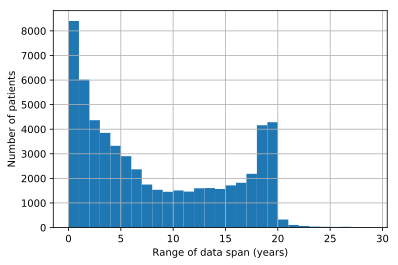

In [0]:
df_daterange['rangeInYears'].hist(bins=range(0,30))
plt.xlabel('Range of data span (years)')
plt.ylabel('Number of patients')
plt.savefig('hist.pdf')